# LLM experiments for sentiment analysis

## Import required packages

In [73]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn import metrics
import numpy as np
import datasets
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from peft import get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType, PromptEncoderConfig
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModel, DistilBertTokenizer, DistilBertModel,DataCollatorForLanguageModeling, TrainingArguments, Trainer, DataCollatorWithPadding
import torch


## Load Abels english dataset and test permormance

In [2]:
data = pd.read_csv('LLM_examples.csv', sep=';')

In [3]:
data.head()

,Sentence,Sentiment
0,I absolutely loved the new movie; it was fanta...,Positive
1,The customer service was excellent; they were ...,Positive
2,This is the best product I've ever used; highl...,Positive
3,I’m so happy with my recent purchase; it excee...,Positive
4,The event was incredibly well-organized and en...,Positive


## Test performance of task specific models

In [4]:
# Define the model repo
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest" 


# Download pytorch model
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/CA39WS/Repositories/llm-experiments/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be

In [5]:
def sentiment_score(review):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits))

In [6]:
data['Predicted_sentiment'] = data['Sentence'].apply(lambda x: sentiment_score(x[:512]))

In [7]:
data

,Sentence,Sentiment,Predicted_sentiment
0,I absolutely loved the new movie; it was fanta...,Positive,2
1,The customer service was excellent; they were ...,Positive,2
2,This is the best product I've ever used; highl...,Positive,2
3,I’m so happy with my recent purchase; it excee...,Positive,2
4,The event was incredibly well-organized and en...,Positive,2
...,...,...,...
1015,Watched a few episodes of a show I’m catching ...,Neutral,2
1016,"The mail today was mostly bills, just the usual.",Neutral,1
1017,"Went for a walk around the neighborhood, it wa...",Neutral,2
1018,"Did a load of laundry this morning, just part ...",Neutral,1


In [8]:
data['Sentiment'] = data['Sentiment'].apply(lambda x: 2 if x == 'Positive' else 0 if x == 'Negative' else 1)
data.head()

,Sentence,Sentiment,Predicted_sentiment
0,I absolutely loved the new movie; it was fanta...,2,2
1,The customer service was excellent; they were ...,2,2
2,This is the best product I've ever used; highl...,2,2
3,I’m so happy with my recent purchase; it excee...,2,2
4,The event was incredibly well-organized and en...,2,2


In [9]:
# define confusion matrix
confusion_matrix = metrics.confusion_matrix(data['Sentiment'], data['Predicted_sentiment'])

print(confusion_matrix)

[[335   3   2]
 [ 19 157 164]
 [  0   0 340]]


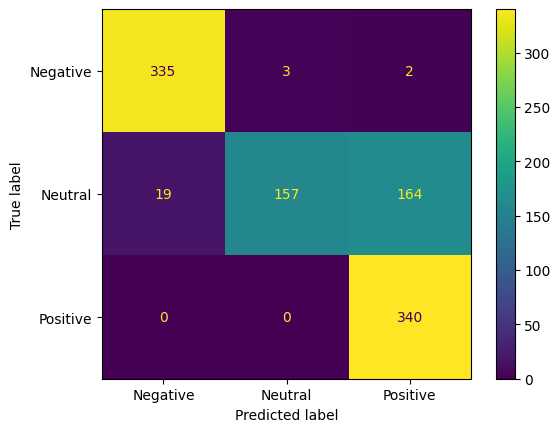

In [10]:
# visualize confusion matrix with sklearn metrics
# define matrix and create labels
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Negative", "Neutral", "Positive"])

# display matrix
cm_display.plot()
plt.show()

## Test performance of much smaller model

In [11]:

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=3)

def sentiment_score(review):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits))

data['Predicted_sentiment'] = data['Sentence'].apply(lambda x: sentiment_score(x[:512]))

/Users/CA39WS/Repositories/llm-experiments/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[[  0   0 340]
 [  0   0 340]
 [  0   0 340]]


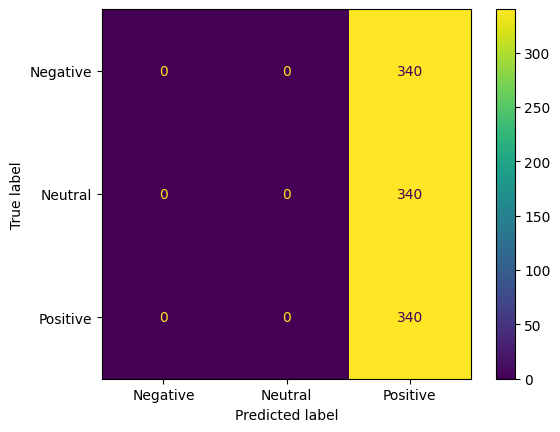

In [12]:
# define confusion matrix
confusion_matrix = metrics.confusion_matrix(data['Sentiment'], data['Predicted_sentiment'])

print(confusion_matrix)

# visualize confusion matrix with sklearn metrics
# define matrix and create labels
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Negative", "Neutral", "Positive"])

# display matrix
cm_display.plot()
plt.show()

We can see that the model performs very bad. Let's try finetuning it.

In [25]:
data = data.rename(columns={"Sentence": "text", "Sentiment": "label"})
data.reset_index(inplace=True, drop = True)

In [26]:
data.head()

,text,label,Predicted_sentiment
0,I absolutely loved the new movie; it was fanta...,2,2
1,The customer service was excellent; they were ...,2,2
2,This is the best product I've ever used; highl...,2,2
3,I’m so happy with my recent purchase; it excee...,2,2
4,The event was incredibly well-organized and en...,2,2


In [27]:
train, test = train_test_split(
    data, test_size=0.2, random_state=42,stratify= data['label'])

train, validation = train_test_split(
    train, test_size=0.2, random_state=42
)

In [28]:
#Creating Dataset Objects
dataset_train = datasets.Dataset.from_pandas(train)
dataset_test = datasets.Dataset.from_pandas(test)
dataset_val = datasets.Dataset.from_pandas(validation)

In [29]:
# let's train a Distilbert model
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# let's tokenize the data for the model to be able to understand
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

sentences_train_encoded = dataset_train.map(tokenize, batched=True)
# sentences_train_encoded = sentences_train_encoded.remove_columns(dataset_train.column_names)
sentences_test_encoded = dataset_test.map(tokenize, batched=True)
# sentences_test_encoded = sentences_test_encoded.remove_columns(dataset_test.column_names)
sentences_validation_encoded = dataset_val.map(tokenize, batched=True)
# sentences_validation_encoded = sentences_validation_encoded.remove_columns(dataset_val.column_names)

/Users/CA39WS/Repositories/llm-experiments/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 164/164 [00:00<00:00, 29401.00 examples/s]


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 3
id2label = {
    "0": "Negative",
    "1": "Neutral",
    "2": "Positive"
}
label2id = {
    "0": "Negative",
    "1": "Neutral",
    "2": "Positive"
}

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id).to(device)

In [31]:

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [32]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(sentences_train_encoded) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=sentences_train_encoded,
    eval_dataset=sentences_validation_encoded,
    tokenizer=tokenizer
)

/Users/CA39WS/Repositories/llm-experiments/.venv/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
trainer.train()


  9%|▉         | 10/110 [00:02<00:20,  4.88it/s]

{'loss': 1.0686, 'grad_norm': 1.239301085472107, 'learning_rate': 1.8181818181818182e-05, 'epoch': 0.91}


                                                
 10%|█         | 11/110 [00:02<00:20,  4.88it/s]

{'eval_loss': 0.9710049629211426, 'eval_accuracy': 0.8841463414634146, 'eval_f1': 0.8842438775393879, 'eval_runtime': 0.1794, 'eval_samples_per_second': 913.929, 'eval_steps_per_second': 16.718, 'epoch': 1.0}


 18%|█▊        | 20/110 [00:04<00:18,  4.85it/s]

{'loss': 0.8923, 'grad_norm': 2.283160448074341, 'learning_rate': 1.6363636363636366e-05, 'epoch': 1.82}


                                                
 20%|██        | 22/110 [00:04<00:18,  4.86it/s]

{'eval_loss': 0.6877902746200562, 'eval_accuracy': 0.9207317073170732, 'eval_f1': 0.9197763445473927, 'eval_runtime': 0.1705, 'eval_samples_per_second': 962.085, 'eval_steps_per_second': 17.599, 'epoch': 2.0}


 27%|██▋       | 30/110 [00:06<00:16,  4.84it/s]

{'loss': 0.6204, 'grad_norm': 2.5944583415985107, 'learning_rate': 1.4545454545454546e-05, 'epoch': 2.73}


                                                
 30%|███       | 33/110 [00:06<00:15,  4.85it/s]

{'eval_loss': 0.4138137102127075, 'eval_accuracy': 0.975609756097561, 'eval_f1': 0.975676085432183, 'eval_runtime': 0.1704, 'eval_samples_per_second': 962.543, 'eval_steps_per_second': 17.607, 'epoch': 3.0}


 36%|███▋      | 40/110 [00:08<00:14,  4.82it/s]

{'loss': 0.3792, 'grad_norm': 2.1684377193450928, 'learning_rate': 1.2727272727272728e-05, 'epoch': 3.64}


                                                
 40%|████      | 44/110 [00:09<00:13,  4.84it/s]

{'eval_loss': 0.2484586238861084, 'eval_accuracy': 0.9817073170731707, 'eval_f1': 0.981762200195181, 'eval_runtime': 0.1698, 'eval_samples_per_second': 966.116, 'eval_steps_per_second': 17.673, 'epoch': 4.0}


 45%|████▌     | 50/110 [00:10<00:12,  4.82it/s]

{'loss': 0.2259, 'grad_norm': 1.571728229522705, 'learning_rate': 1.0909090909090909e-05, 'epoch': 4.55}


                                                
 50%|█████     | 55/110 [00:11<00:11,  4.89it/s]

{'eval_loss': 0.1610012799501419, 'eval_accuracy': 0.9817073170731707, 'eval_f1': 0.9817208108671525, 'eval_runtime': 0.1706, 'eval_samples_per_second': 961.042, 'eval_steps_per_second': 17.58, 'epoch': 5.0}


 55%|█████▍    | 60/110 [00:12<00:10,  4.84it/s]

{'loss': 0.138, 'grad_norm': 1.1427245140075684, 'learning_rate': 9.090909090909091e-06, 'epoch': 5.45}


                                                
 60%|██████    | 66/110 [00:13<00:09,  4.87it/s]

{'eval_loss': 0.11640527844429016, 'eval_accuracy': 0.9878048780487805, 'eval_f1': 0.9878096158583964, 'eval_runtime': 0.1719, 'eval_samples_per_second': 954.004, 'eval_steps_per_second': 17.451, 'epoch': 6.0}


 65%|██████▍   | 71/110 [00:14<00:08,  4.85it/s]

{'loss': 0.0884, 'grad_norm': 1.140876054763794, 'learning_rate': 7.272727272727273e-06, 'epoch': 6.36}


                                                
 70%|███████   | 77/110 [00:16<00:06,  4.97it/s]

{'eval_loss': 0.09876883774995804, 'eval_accuracy': 0.9878048780487805, 'eval_f1': 0.9878096158583964, 'eval_runtime': 0.1683, 'eval_samples_per_second': 974.577, 'eval_steps_per_second': 17.828, 'epoch': 7.0}


 73%|███████▎  | 80/110 [00:16<00:06,  4.77it/s]

{'loss': 0.0646, 'grad_norm': 0.4342135190963745, 'learning_rate': 5.4545454545454545e-06, 'epoch': 7.27}


                                                
 80%|████████  | 88/110 [00:18<00:04,  4.96it/s]

{'eval_loss': 0.08907099813222885, 'eval_accuracy': 0.9878048780487805, 'eval_f1': 0.9878096158583964, 'eval_runtime': 0.1701, 'eval_samples_per_second': 963.885, 'eval_steps_per_second': 17.632, 'epoch': 8.0}


 82%|████████▏ | 90/110 [00:18<00:04,  4.76it/s]

{'loss': 0.054, 'grad_norm': 0.4358142614364624, 'learning_rate': 3.6363636363636366e-06, 'epoch': 8.18}


                                                
 90%|█████████ | 99/110 [00:20<00:02,  4.90it/s]

{'eval_loss': 0.08494775742292404, 'eval_accuracy': 0.9878048780487805, 'eval_f1': 0.9878096158583964, 'eval_runtime': 0.1701, 'eval_samples_per_second': 964.208, 'eval_steps_per_second': 17.638, 'epoch': 9.0}


 91%|█████████ | 100/110 [00:20<00:02,  4.63it/s]

{'loss': 0.0468, 'grad_norm': 0.3994918465614319, 'learning_rate': 1.8181818181818183e-06, 'epoch': 9.09}


100%|██████████| 110/110 [00:22<00:00,  4.89it/s]

{'loss': 0.0442, 'grad_norm': 0.6219150424003601, 'learning_rate': 0.0, 'epoch': 10.0}


                                                 
100%|██████████| 110/110 [00:24<00:00,  4.55it/s]

{'eval_loss': 0.08409831672906876, 'eval_accuracy': 0.9878048780487805, 'eval_f1': 0.9878096158583964, 'eval_runtime': 0.1897, 'eval_samples_per_second': 864.514, 'eval_steps_per_second': 15.814, 'epoch': 10.0}
{'train_runtime': 24.167, 'train_samples_per_second': 269.79, 'train_steps_per_second': 4.552, 'train_loss': 0.3293091142719442, 'epoch': 10.0}


TrainOutput(global_step=110, training_loss=0.3293091142719442, metrics={'train_runtime': 24.167, 'train_samples_per_second': 269.79, 'train_steps_per_second': 4.552, 'total_flos': 43859909939040.0, 'train_loss': 0.3293091142719442, 'epoch': 10.0})

In [34]:
preds_output = trainer.predict(sentences_validation_encoded)
preds_output.metrics

100%|██████████| 3/3 [00:00<00:00, 29.47it/s]


{'test_loss': 0.08409831672906876,
 'test_accuracy': 0.9878048780487805,
 'test_f1': 0.9878096158583964,
 'test_runtime': 0.2417,
 'test_samples_per_second': 678.547,
 'test_steps_per_second': 12.412}

In [35]:
preds_output = trainer.predict(sentences_test_encoded)
preds_output.metrics

100%|██████████| 4/4 [00:00<00:00, 27.79it/s]


{'test_loss': 0.059693966060876846,
 'test_accuracy': 0.9950980392156863,
 'test_f1': 0.9950977741731999,
 'test_runtime': 0.2303,
 'test_samples_per_second': 885.747,
 'test_steps_per_second': 17.368}

[[67  0  1]
 [ 0 68  0]
 [ 0  0 68]]


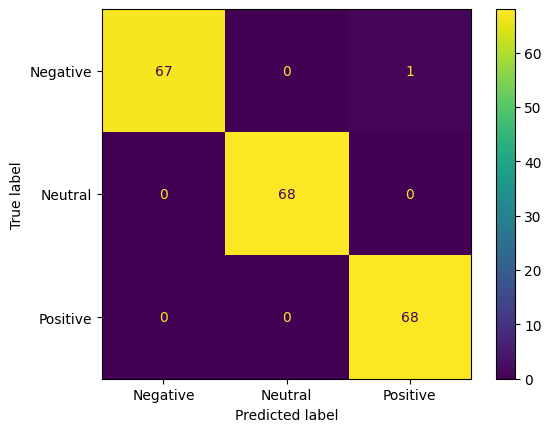

In [36]:
# define confusion matrix
confusion_matrix = metrics.confusion_matrix(sentences_test_encoded['label'], np.argmax(preds_output.predictions, axis=1))

print(confusion_matrix)

# visualize confusion matrix with sklearn metrics
# define matrix and create labels
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Negative", "Neutral", "Positive"])

# display matrix
cm_display.plot()
plt.show()

## Lets train only using PEFT

In [37]:
data = pd.read_csv('LLM_examples.csv', sep=';')
data['Sentiment'] = data['Sentiment'].apply(lambda x: 2 if x == 'Positive' else 0 if x == 'Negative' else 1)
data = data.rename(columns={"Sentence": "text", "Sentiment": "labels"})
data.reset_index(inplace=True, drop = True)

train, test = train_test_split(
    data, test_size=0.2, random_state=42,stratify= data['labels'])

train, validation = train_test_split(
    train, test_size=0.2, random_state=42
)

#Creating Dataset Objects
dataset_train = datasets.Dataset.from_pandas(train)
dataset_test = datasets.Dataset.from_pandas(test)
dataset_val = datasets.Dataset.from_pandas(validation)

# let's train a Distilbert model

from transformers import AutoTokenizer
model_ckpt = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# let's tokenize the data for the model to be able to understand
def tokenize(batch):
    return tokenizer(batch["text"], padding='max_length', truncation=True, max_length=208)

sentences_train_encoded = dataset_train.map(tokenize, batched=True)
# sentences_train_encoded = sentences_train_encoded.remove_columns(dataset_train.column_names)
sentences_test_encoded = dataset_test.map(tokenize, batched=True)
# sentences_test_encoded = sentences_test_encoded.remove_columns(dataset_test.column_names)
sentences_validation_encoded = dataset_val.map(tokenize, batched=True)
# sentences_validation_encoded = sentences_validation_encoded.remove_columns(dataset_val.column_names)

/Users/CA39WS/Repositories/llm-experiments/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 164/164 [00:00<00:00, 16699.02 examples/s]


In [38]:
foundation_model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id).to(device)

# Create a configuration for prompt tuning using the PromptTuningConfig class
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,
    prompt_tuning_init=PromptTuningInit.RANDOM,
    num_virtual_tokens=4,
    num_layers=1,
    token_dim=768,
    num_attention_heads=3,
    tokenizer_name_or_path=model_ckpt
)

# Get a PeftModel using the specified foundation_model and prompt tuning configuration
peft_model = get_peft_model(foundation_model, peft_config)

# Print the trainable parameters of the PeftModel
print(peft_model.print_trainable_parameters())

trainable params: 595,971 || all params: 67,551,750 || trainable%: 0.8822
None


In [41]:
output_directory = f"models/{model_ckpt}/peft_outputs"

# Define training arguments for the Peft model
training_args = TrainingArguments(
    output_dir=output_directory,  # Where the model predictions and checkpoints will be written
    no_cuda=False,  # This is necessary for CPU clusters.
    auto_find_batch_size=False,  # Find a suitable batch size that will fit into memory automatically
    learning_rate=2e-5,  # Higher learning rate than full fine-tuning
    num_train_epochs=10,  # Number of passes to go through the entire fine-tuning dataset
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    log_level="error"
)

# Create a Trainer instance for training the Peft model
trainer = Trainer(
    model=peft_model,  # We pass in the PEFT version of the foundation model, bloomz-560M
    args=training_args,  # Training arguments specifying output directory, GPU usage, batch size, etc.
    compute_metrics=compute_metrics,
    train_dataset=sentences_train_encoded,  # Training dataset
    eval_dataset=sentences_validation_encoded,
    data_collator=DataCollatorWithPadding(tokenizer) 
)

# Start the training process
trainer.train()

                                                
 10%|█         | 83/820 [00:14<07:41,  1.60it/s]

{'eval_loss': 1.066786289215088, 'eval_accuracy': 0.573170731707317, 'eval_f1': 0.5419345088668345, 'eval_runtime': 1.5064, 'eval_samples_per_second': 108.871, 'eval_steps_per_second': 13.941, 'epoch': 1.0}


 20%|██        | 165/820 [00:28<05:22,  2.03it/s]

{'eval_loss': 1.0436785221099854, 'eval_accuracy': 0.8536585365853658, 'eval_f1': 0.8537802322014836, 'eval_runtime': 1.5323, 'eval_samples_per_second': 107.032, 'eval_steps_per_second': 13.705, 'epoch': 2.0}


 30%|███       | 247/820 [00:42<04:41,  2.04it/s]

{'eval_loss': 1.0196168422698975, 'eval_accuracy': 0.8597560975609756, 'eval_f1': 0.8600727156357201, 'eval_runtime': 1.5356, 'eval_samples_per_second': 106.802, 'eval_steps_per_second': 13.676, 'epoch': 3.0}


                                                 
 40%|████      | 329/820 [00:56<04:10,  1.96it/s]

{'eval_loss': 0.9967029690742493, 'eval_accuracy': 0.8536585365853658, 'eval_f1': 0.8529214687751273, 'eval_runtime': 1.5996, 'eval_samples_per_second': 102.529, 'eval_steps_per_second': 13.129, 'epoch': 4.0}


                                                 
 50%|█████     | 411/820 [01:10<03:21,  2.03it/s]

{'eval_loss': 0.9767491221427917, 'eval_accuracy': 0.8597560975609756, 'eval_f1': 0.8599194016064707, 'eval_runtime': 1.5428, 'eval_samples_per_second': 106.302, 'eval_steps_per_second': 13.612, 'epoch': 5.0}


                                                 
 60%|██████    | 493/820 [01:24<02:41,  2.02it/s]

{'eval_loss': 0.9613316059112549, 'eval_accuracy': 0.8536585365853658, 'eval_f1': 0.8539364361842188, 'eval_runtime': 1.5511, 'eval_samples_per_second': 105.729, 'eval_steps_per_second': 13.538, 'epoch': 6.0}


 61%|██████    | 500/820 [01:25<01:00,  5.25it/s]

{'loss': 1.0265, 'grad_norm': 1.7233171463012695, 'learning_rate': 7.804878048780489e-06, 'epoch': 6.1}


                                                 
 70%|███████   | 575/820 [01:39<02:00,  2.03it/s]

{'eval_loss': 0.9491315484046936, 'eval_accuracy': 0.8780487804878049, 'eval_f1': 0.8781147324747584, 'eval_runtime': 1.5332, 'eval_samples_per_second': 106.963, 'eval_steps_per_second': 13.696, 'epoch': 7.0}


                                                 
 80%|████████  | 657/820 [01:53<01:21,  2.01it/s]

{'eval_loss': 0.9396529793739319, 'eval_accuracy': 0.8597560975609756, 'eval_f1': 0.8595203647473196, 'eval_runtime': 1.5552, 'eval_samples_per_second': 105.455, 'eval_steps_per_second': 13.503, 'epoch': 8.0}


                                                 
 90%|█████████ | 739/820 [02:07<00:40,  2.00it/s]

{'eval_loss': 0.9343830943107605, 'eval_accuracy': 0.8597560975609756, 'eval_f1': 0.8594410499609897, 'eval_runtime': 1.5572, 'eval_samples_per_second': 105.314, 'eval_steps_per_second': 13.485, 'epoch': 9.0}


                                                 
100%|██████████| 820/820 [02:21<00:00,  5.79it/s]

{'eval_loss': 0.9324837923049927, 'eval_accuracy': 0.8597560975609756, 'eval_f1': 0.8594410499609897, 'eval_runtime': 1.5409, 'eval_samples_per_second': 106.429, 'eval_steps_per_second': 13.628, 'epoch': 10.0}
{'train_runtime': 141.6145, 'train_samples_per_second': 46.04, 'train_steps_per_second': 5.79, 'train_loss': 0.9959570535799352, 'epoch': 10.0}


TrainOutput(global_step=820, training_loss=0.9959570535799352, metrics={'train_runtime': 141.6145, 'train_samples_per_second': 46.04, 'train_steps_per_second': 5.79, 'total_flos': 355703674959360.0, 'train_loss': 0.9959570535799352, 'epoch': 10.0})

In [42]:
preds_output = trainer.predict(sentences_validation_encoded)
preds_output.metrics

100%|██████████| 21/21 [00:01<00:00, 13.97it/s]


{'test_loss': 0.9324837923049927,
 'test_accuracy': 0.8597560975609756,
 'test_f1': 0.8594410499609897,
 'test_runtime': 1.6475,
 'test_samples_per_second': 99.547,
 'test_steps_per_second': 12.747}

In [43]:
preds_output = trainer.predict(sentences_test_encoded)
preds_output.metrics

100%|██████████| 26/26 [00:01<00:00, 13.70it/s]


{'test_loss': 0.9264066219329834,
 'test_accuracy': 0.8333333333333334,
 'test_f1': 0.8339204939808056,
 'test_runtime': 1.9854,
 'test_samples_per_second': 102.749,
 'test_steps_per_second': 13.095}

[[57  9  2]
 [ 6 59  3]
 [10  4 54]]


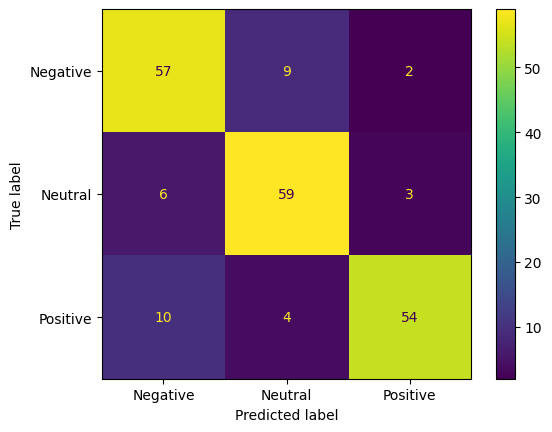

In [44]:
#chech performance
from sklearn import metrics

# define confusion matrix
confusion_matrix = metrics.confusion_matrix(sentences_test_encoded['labels'], np.argmax(preds_output.predictions, axis=1))

print(confusion_matrix)

# visualize confusion matrix with sklearn metrics
# define matrix and create labels
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Negative", "Neutral", "Positive"])

# display matrix
cm_display.plot()
plt.show()

## Training only the last layer of distilbert

In [51]:
data = pd.read_csv('LLM_examples.csv', sep=';')
data['Sentiment'] = data['Sentiment'].apply(lambda x: 2 if x == 'Positive' else 0 if x == 'Negative' else 1)
data = data.rename(columns={"Sentence": "text", "Sentiment": "label"})
data.reset_index(inplace=True, drop = True)

train, test = train_test_split(
    data, test_size=0.2, random_state=42,stratify= data['label'])

train, validation = train_test_split(
    train, test_size=0.2, random_state=42
)

#Creating Dataset Objects
dataset_train = datasets.Dataset.from_pandas(train)
dataset_test = datasets.Dataset.from_pandas(test)
dataset_val = datasets.Dataset.from_pandas(validation)

# let's train a Distilbert model

from transformers import AutoTokenizer
model_ckpt = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# let's tokenize the data for the model to be able to understand
def tokenize(batch):
    return tokenizer(batch["text"], padding='max_length', truncation=True, max_length=208)

sentences_train_encoded = dataset_train.map(tokenize, batched=True)
# sentences_train_encoded = sentences_train_encoded.remove_columns(dataset_train.column_names)
sentences_test_encoded = dataset_test.map(tokenize, batched=True)
# sentences_test_encoded = sentences_test_encoded.remove_columns(dataset_test.column_names)
sentences_validation_encoded = dataset_val.map(tokenize, batched=True)
# sentences_validation_encoded = sentences_validation_encoded.remove_columns(dataset_val.column_names)

/Users/CA39WS/Repositories/llm-experiments/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 164/164 [00:00<00:00, 16555.53 examples/s]


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 3
id2label = {
    "0": "Negative",
    "1": "Neutral",
    "2": "Positive"
}
label2id = {
    "0": "Negative",
    "1": "Neutral",
    "2": "Positive"
}

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id).to(device)

In [53]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [54]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last 2 layers
for param in model.pre_classifier.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

for param in model.dropout.parameters():
    param.requires_grad = True

In [60]:
#show how many parameters we're going to train
param_n = 0
for param in model.pre_classifier.parameters():
    param_n += 1

for param in model.classifier.parameters():
    param_n += 1

for param in model.dropout.parameters():
    param_n += 1



4


In [55]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(sentences_train_encoded) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="steps",
    disable_tqdm=False,
    logging_steps=logging_steps,
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=sentences_train_encoded,
    eval_dataset=sentences_validation_encoded,
    tokenizer=tokenizer
)

/Users/CA39WS/Repositories/llm-experiments/.venv/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [56]:
trainer.train()


                                               
 97%|█████████▋| 64/66 [00:54<00:01,  1.53it/s] 

{'loss': 1.0968, 'grad_norm': 0.5859348773956299, 'learning_rate': 1.8181818181818182e-05, 'epoch': 0.91}





                                               
                                             

 97%|█████████▋| 64/66 [00:55<00:01,  1.53it/s]



{'eval_loss': 1.0845972299575806, 'eval_accuracy': 0.3780487804878049, 'eval_f1': 0.22743476036158963, 'eval_runtime': 1.2116, 'eval_samples_per_second': 135.361, 'eval_steps_per_second': 2.476, 'epoch': 0.91}


                                               
 97%|█████████▋| 64/66 [01:00<00:01,  1.53it/s] 

{'loss': 1.0825, 'grad_norm': 1.069106101989746, 'learning_rate': 1.6363636363636366e-05, 'epoch': 1.82}





                                               
                                             

 97%|█████████▋| 64/66 [01:01<00:01,  1.53it/s]



{'eval_loss': 1.0743885040283203, 'eval_accuracy': 0.5182926829268293, 'eval_f1': 0.42775601896727883, 'eval_runtime': 1.2196, 'eval_samples_per_second': 134.468, 'eval_steps_per_second': 2.46, 'epoch': 1.82}


                                               
 97%|█████████▋| 64/66 [01:06<00:01,  1.53it/s] 

{'loss': 1.0701, 'grad_norm': 0.8992363214492798, 'learning_rate': 1.4545454545454546e-05, 'epoch': 2.73}





                                               
                                             

 97%|█████████▋| 64/66 [01:07<00:01,  1.53it/s]



{'eval_loss': 1.0664523839950562, 'eval_accuracy': 0.6036585365853658, 'eval_f1': 0.5243961637406845, 'eval_runtime': 1.1841, 'eval_samples_per_second': 138.498, 'eval_steps_per_second': 2.534, 'epoch': 2.73}


                                               
 97%|█████████▋| 64/66 [01:12<00:01,  1.53it/s] 

{'loss': 1.0622, 'grad_norm': 0.5637362003326416, 'learning_rate': 1.2727272727272728e-05, 'epoch': 3.64}





                                               
                                             

 97%|█████████▋| 64/66 [01:14<00:01,  1.53it/s]



{'eval_loss': 1.0596524477005005, 'eval_accuracy': 0.7317073170731707, 'eval_f1': 0.6964225521651684, 'eval_runtime': 1.2349, 'eval_samples_per_second': 132.799, 'eval_steps_per_second': 2.429, 'epoch': 3.64}


                                               
 97%|█████████▋| 64/66 [01:19<00:01,  1.53it/s] 

{'loss': 1.0629, 'grad_norm': 0.8800718784332275, 'learning_rate': 1.0909090909090909e-05, 'epoch': 4.55}





                                               
                                             

 97%|█████████▋| 64/66 [01:20<00:01,  1.53it/s]



{'eval_loss': 1.0534902811050415, 'eval_accuracy': 0.7378048780487805, 'eval_f1': 0.7192809108930466, 'eval_runtime': 1.2289, 'eval_samples_per_second': 133.45, 'eval_steps_per_second': 2.441, 'epoch': 4.55}


                                               
 97%|█████████▋| 64/66 [01:25<00:01,  1.53it/s] 

{'loss': 1.0535, 'grad_norm': 0.630263090133667, 'learning_rate': 9.090909090909091e-06, 'epoch': 5.45}





                                               
                                             

 97%|█████████▋| 64/66 [01:26<00:01,  1.53it/s]



{'eval_loss': 1.048353672027588, 'eval_accuracy': 0.7682926829268293, 'eval_f1': 0.7614911188994588, 'eval_runtime': 1.2304, 'eval_samples_per_second': 133.291, 'eval_steps_per_second': 2.438, 'epoch': 5.45}


                                               
 97%|█████████▋| 64/66 [01:31<00:01,  1.53it/s] 

{'loss': 1.0472, 'grad_norm': 0.7463626265525818, 'learning_rate': 7.272727272727273e-06, 'epoch': 6.36}





                                               
                                             

 97%|█████████▋| 64/66 [01:32<00:01,  1.53it/s]



{'eval_loss': 1.0439770221710205, 'eval_accuracy': 0.7804878048780488, 'eval_f1': 0.7755076201129615, 'eval_runtime': 1.2249, 'eval_samples_per_second': 133.888, 'eval_steps_per_second': 2.449, 'epoch': 6.36}


                                               
 97%|█████████▋| 64/66 [01:37<00:01,  1.53it/s] 

{'loss': 1.0451, 'grad_norm': 0.5316279530525208, 'learning_rate': 5.4545454545454545e-06, 'epoch': 7.27}





                                               
                                             

 97%|█████████▋| 64/66 [01:38<00:01,  1.53it/s]



{'eval_loss': 1.040513038635254, 'eval_accuracy': 0.7865853658536586, 'eval_f1': 0.782424908824349, 'eval_runtime': 1.225, 'eval_samples_per_second': 133.883, 'eval_steps_per_second': 2.449, 'epoch': 7.27}


                                               
 97%|█████████▋| 64/66 [01:43<00:01,  1.53it/s] 

{'loss': 1.039, 'grad_norm': 0.638657808303833, 'learning_rate': 3.6363636363636366e-06, 'epoch': 8.18}





                                               
                                             

 97%|█████████▋| 64/66 [01:44<00:01,  1.53it/s]



{'eval_loss': 1.0379730463027954, 'eval_accuracy': 0.7926829268292683, 'eval_f1': 0.7892868497995705, 'eval_runtime': 1.2124, 'eval_samples_per_second': 135.266, 'eval_steps_per_second': 2.474, 'epoch': 8.18}


                                               
 97%|█████████▋| 64/66 [01:49<00:01,  1.53it/s]  

{'loss': 1.0404, 'grad_norm': 0.5490288138389587, 'learning_rate': 1.8181818181818183e-06, 'epoch': 9.09}





                                               
                                              

 97%|█████████▋| 64/66 [01:51<00:01,  1.53it/s]



{'eval_loss': 1.0364437103271484, 'eval_accuracy': 0.7926829268292683, 'eval_f1': 0.7892868497995705, 'eval_runtime': 1.2003, 'eval_samples_per_second': 136.637, 'eval_steps_per_second': 2.499, 'epoch': 9.09}


                                               
 97%|█████████▋| 64/66 [01:56<00:01,  1.53it/s]  

{'loss': 1.0358, 'grad_norm': 2.2430648803710938, 'learning_rate': 0.0, 'epoch': 10.0}





                                               
                                              

 97%|█████████▋| 64/66 [01:57<00:01,  1.53it/s]

                                               
100%|██████████| 110/110 [01:08<00:00,  1.61it/s]

{'eval_loss': 1.0358816385269165, 'eval_accuracy': 0.7987804878048781, 'eval_f1': 0.7960972970119311, 'eval_runtime': 1.202, 'eval_samples_per_second': 136.434, 'eval_steps_per_second': 2.496, 'epoch': 10.0}
{'train_runtime': 68.2278, 'train_samples_per_second': 95.562, 'train_steps_per_second': 1.612, 'train_loss': 1.0577676252885297, 'epoch': 10.0}


TrainOutput(global_step=110, training_loss=1.0577676252885297, metrics={'train_runtime': 68.2278, 'train_samples_per_second': 95.562, 'train_steps_per_second': 1.612, 'total_flos': 350879279512320.0, 'train_loss': 1.0577676252885297, 'epoch': 10.0})

In [57]:
preds_output = trainer.predict(sentences_validation_encoded)
preds_output.metrics

100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


{'test_loss': 1.0358816385269165,
 'test_accuracy': 0.7987804878048781,
 'test_f1': 0.7960972970119311,
 'test_runtime': 1.2184,
 'test_samples_per_second': 134.598,
 'test_steps_per_second': 2.462}

In [58]:
preds_output = trainer.predict(sentences_test_encoded)
preds_output.metrics

100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


{'test_loss': 1.0348583459854126,
 'test_accuracy': 0.8529411764705882,
 'test_f1': 0.8534452003461375,
 'test_runtime': 1.5256,
 'test_samples_per_second': 133.72,
 'test_steps_per_second': 2.622}

[[55  2 11]
 [ 5 54  9]
 [ 3  0 65]]


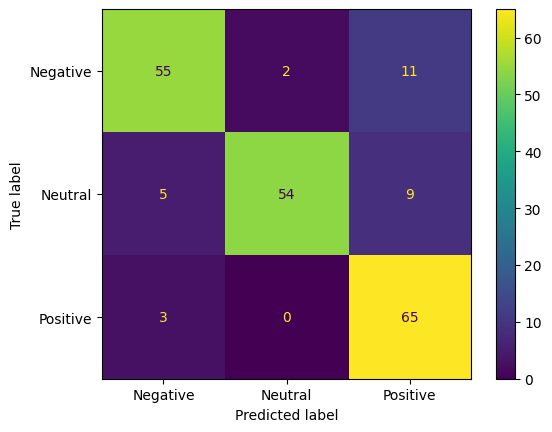

In [59]:
# define confusion matrix
confusion_matrix = metrics.confusion_matrix(sentences_test_encoded['label'], np.argmax(preds_output.predictions, axis=1))

print(confusion_matrix)

# visualize confusion matrix with sklearn metrics
# define matrix and create labels
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Negative", "Neutral", "Positive"])

# display matrix
cm_display.plot()
plt.show()

## Prompt tuning

In [99]:
data = pd.read_csv('LLM_examples.csv', sep=';')
data['Sentiment'] = data['Sentiment'].apply(lambda x: 2 if x == 'Positive' else 0 if x == 'Negative' else 1)
data = data.rename(columns={"Sentence": "text", "Sentiment": "labels"})
data.reset_index(inplace=True, drop = True)

train, test = train_test_split(
    data, test_size=0.2, random_state=42,stratify= data['labels'])

train, validation = train_test_split(
    train, test_size=0.2, random_state=42
)

#Creating Dataset Objects
dataset_train = datasets.Dataset.from_pandas(train)
dataset_test = datasets.Dataset.from_pandas(test)
dataset_val = datasets.Dataset.from_pandas(validation)

# let's train a Distilbert model

from transformers import AutoTokenizer
model_ckpt = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# let's tokenize the data for the model to be able to understand
def tokenize(batch):
    return tokenizer(batch["text"], padding='max_length', truncation=True, max_length=208)

sentences_train_encoded = dataset_train.map(tokenize, batched=True)
sentences_test_encoded = dataset_test.map(tokenize, batched=True)
sentences_validation_encoded = dataset_val.map(tokenize, batched=True)

foundation_model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id).to(device)

# Create a configuration for prompt tuning using the PromptTuningConfig class
# peft_config = PromptEncoderConfig(
#     task_type=TaskType.SEQ_CLS,
#     num_layers=1,
#     token_dim=768,
#     num_attention_heads=3,
#     num_virtual_tokens=20, 
#     encoder_hidden_size=128
# )

# Create a configuration for prompt tuning using the PromptTuningConfig class
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,
    prompt_tuning_init="TEXT",
    prompt_tuning_init_text = "Classify the text into the following labels: 'Negative','Neutral' and 'Positive'",
    num_virtual_tokens=16,
    num_layers=1,
    token_dim=768,
    num_attention_heads=3,
    tokenizer_name_or_path=model_ckpt
)

# Get a PeftModel using the specified foundation_model and prompt tuning configuration
model = get_peft_model(foundation_model, peft_config)

# Print the trainable parameters of the PeftModel
print(model.print_trainable_parameters())

/Users/CA39WS/Repositories/llm-experiments/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 164/164 [00:00<00:00, 16016.99 examples/s]


trainable params: 605,187 || all params: 67,560,966 || trainable%: 0.8958
None


In [100]:
output_directory = f"models/{model_ckpt}/prompt_tune_outputs"

# Define training arguments for the Peft model
training_args = TrainingArguments(
    output_dir=output_directory,
    no_cuda=False,  # This is necessary for CPU clusters.
    auto_find_batch_size=False,  # Find a suitable batch size that will fit into memory automatically
    learning_rate=2e-5,  # Higher learning rate than full fine-tuning
    num_train_epochs=10,  # Number of passes to go through the entire fine-tuning dataset
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    log_level="error"
)

# Create a Trainer instance for training the Peft model
trainer = Trainer(
    model=model,  # We pass in the PEFT version of the foundation model, bloomz-560M
    args=training_args,  # Training arguments specifying output directory, GPU usage, batch size, etc.
    compute_metrics=compute_metrics,
    train_dataset=sentences_train_encoded,  # Training dataset
    eval_dataset=sentences_validation_encoded,
    data_collator=DataCollatorWithPadding(tokenizer) 
)

# Start the training process
trainer.train()

                                                
 10%|█         | 83/820 [00:15<08:12,  1.50it/s]

{'eval_loss': 1.0738246440887451, 'eval_accuracy': 0.6097560975609756, 'eval_f1': 0.5845556103181953, 'eval_runtime': 1.649, 'eval_samples_per_second': 99.455, 'eval_steps_per_second': 12.735, 'epoch': 1.0}


                                                 
 20%|██        | 165/820 [00:30<05:57,  1.83it/s]

{'eval_loss': 1.052324652671814, 'eval_accuracy': 0.7621951219512195, 'eval_f1': 0.7590380913694112, 'eval_runtime': 1.7178, 'eval_samples_per_second': 95.469, 'eval_steps_per_second': 12.225, 'epoch': 2.0}


                                                 
 30%|███       | 247/820 [00:45<04:59,  1.91it/s]

{'eval_loss': 1.0261492729187012, 'eval_accuracy': 0.7560975609756098, 'eval_f1': 0.754646871270125, 'eval_runtime': 1.6411, 'eval_samples_per_second': 99.932, 'eval_steps_per_second': 12.796, 'epoch': 3.0}


                                                 
 40%|████      | 329/820 [01:00<04:19,  1.90it/s]

{'eval_loss': 0.9966621398925781, 'eval_accuracy': 0.8292682926829268, 'eval_f1': 0.8282893896773403, 'eval_runtime': 1.6584, 'eval_samples_per_second': 98.888, 'eval_steps_per_second': 12.662, 'epoch': 4.0}


                                                 
 50%|█████     | 411/820 [01:14<03:32,  1.92it/s]

{'eval_loss': 0.9693390727043152, 'eval_accuracy': 0.823170731707317, 'eval_f1': 0.8222793911509094, 'eval_runtime': 1.6357, 'eval_samples_per_second': 100.262, 'eval_steps_per_second': 12.838, 'epoch': 5.0}


                                                 
 60%|██████    | 493/820 [01:29<02:50,  1.92it/s]

{'eval_loss': 0.9474124312400818, 'eval_accuracy': 0.8292682926829268, 'eval_f1': 0.8285747602758395, 'eval_runtime': 1.6259, 'eval_samples_per_second': 100.87, 'eval_steps_per_second': 12.916, 'epoch': 6.0}


 61%|██████    | 500/820 [01:30<01:03,  5.01it/s]

{'loss': 1.0271, 'grad_norm': 2.1628379821777344, 'learning_rate': 7.804878048780489e-06, 'epoch': 6.1}


                                                 
 70%|███████   | 575/820 [01:44<02:07,  1.92it/s]

{'eval_loss': 0.9289377927780151, 'eval_accuracy': 0.8353658536585366, 'eval_f1': 0.8345346800676049, 'eval_runtime': 1.6236, 'eval_samples_per_second': 101.013, 'eval_steps_per_second': 12.935, 'epoch': 7.0}


                                                 
 80%|████████  | 657/820 [01:59<01:25,  1.92it/s]

{'eval_loss': 0.9147869348526001, 'eval_accuracy': 0.8353658536585366, 'eval_f1': 0.8342076036219769, 'eval_runtime': 1.6305, 'eval_samples_per_second': 100.582, 'eval_steps_per_second': 12.879, 'epoch': 8.0}


                                                 
 90%|█████████ | 739/820 [02:14<00:42,  1.91it/s]

{'eval_loss': 0.9066444039344788, 'eval_accuracy': 0.8353658536585366, 'eval_f1': 0.8337907555424432, 'eval_runtime': 1.6389, 'eval_samples_per_second': 100.065, 'eval_steps_per_second': 12.813, 'epoch': 9.0}


                                                 
100%|██████████| 820/820 [02:29<00:00,  5.49it/s]

{'eval_loss': 0.9036896824836731, 'eval_accuracy': 0.8414634146341463, 'eval_f1': 0.8402461036701458, 'eval_runtime': 1.652, 'eval_samples_per_second': 99.274, 'eval_steps_per_second': 12.712, 'epoch': 10.0}
{'train_runtime': 149.3557, 'train_samples_per_second': 43.654, 'train_steps_per_second': 5.49, 'train_loss': 0.9860754245665015, 'epoch': 10.0}


TrainOutput(global_step=820, training_loss=0.9860754245665015, metrics={'train_runtime': 149.3557, 'train_samples_per_second': 43.654, 'train_steps_per_second': 5.49, 'total_flos': 355703674959360.0, 'train_loss': 0.9860754245665015, 'epoch': 10.0})

In [101]:
preds_output = trainer.predict(sentences_validation_encoded)
preds_output.metrics

100%|██████████| 21/21 [00:01<00:00, 13.70it/s]


{'test_loss': 0.9036896824836731,
 'test_accuracy': 0.8414634146341463,
 'test_f1': 0.8402461036701458,
 'test_runtime': 1.6054,
 'test_samples_per_second': 102.152,
 'test_steps_per_second': 13.08}

In [102]:
preds_output = trainer.predict(sentences_test_encoded)
preds_output.metrics

100%|██████████| 26/26 [00:01<00:00, 13.20it/s]


{'test_loss': 0.9036296606063843,
 'test_accuracy': 0.8333333333333334,
 'test_f1': 0.832712215320911,
 'test_runtime': 2.0421,
 'test_samples_per_second': 99.895,
 'test_steps_per_second': 12.732}

[[58  6  4]
 [10 52  6]
 [ 4  4 60]]


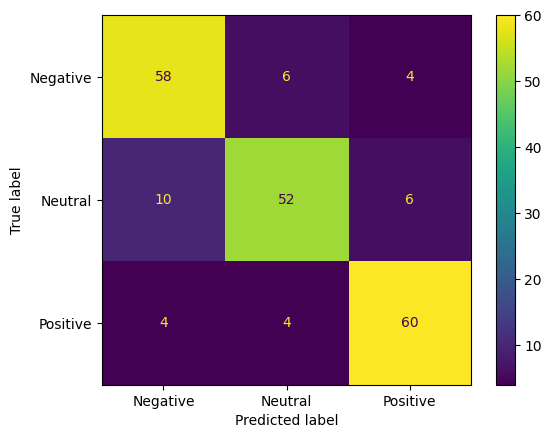

In [103]:
# define confusion matrix
confusion_matrix = metrics.confusion_matrix(sentences_test_encoded['labels'], np.argmax(preds_output.predictions, axis=1))

print(confusion_matrix)

# visualize confusion matrix with sklearn metrics
# define matrix and create labels
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Negative", "Neutral", "Positive"])

# display matrix
cm_display.plot()
plt.show()